# Ablation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 04.08.2023

## 1. Setup

### 1.1 Import Libraries

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import sys
sys.path.append("../../utils")

In [24]:
import os
import warnings
from datetime import datetime

import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable

#from nichecompass.benchmarking import compute_benchmarking_metrics
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

import scanpy as sc

#from ablation_utils import *

### 1.2 Define Parameters

In [25]:
latent_key = "nichecompass_latent"
spatial_key = "spatial"
latent_knng_key = "nichecompass_latent_knng"
spatial_knng_key = "spatial_knng"
gp_names_key = "nichecompass_gp_names"

In [26]:
metric_cols_sample_integration = [
    "gcs", "mlami", "cas", "clisis", # spatial conservation
    "geri", "cari", "cnmi", "casw", "clisi", # biological conservation
    "nasw", # niche identification
    "basw", "bgc", "blisi" # batch correction
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/6), (1/6), (1/3), (1/3), # spatial conservation
    (2/3), (1/12), (1/12), (1/12), (1/12), # biological conservation
    1.0, # niche separability
    (1/3), (1/3), (1,3) # batch correction
]
metric_col_titles_sample_integration = [
    "Graph Connectivity Similarity",
    "Maximum Leiden Adjusted Mutual Info",
    "Cell Type Affinity Similarity",
    "Cell Type Local Inverse Simpson's Index Similarity",
    "Gene Expression Reconstruction Index",
    "Cell Type Adjusted Rand Index",
    "Cell Type Normalized Mutual Info",
    "Cell Type Average Silhouette Width",
    "Cell Type Local Inverse Simpson's Index",
    "Niche Average Silhouette Width",
    "Batch Average Silhouette Width",
    "Batch Graph Connectivity",
    "Batch Local Inverse Simpson's Index"
]
metric_cols_single_sample = metric_cols_sample_integration[:-3]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-3]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-3]

category_cols_sample_integration = [
    "Spatial Conservation Score",
    "Biological Conservation Score",
    "Niche Separability Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    1,
    1]
category_col_titles_sample_integration = [
    "Spatial Conservation Score (25%)",
    "Biological Conservation Score (25%)",
    "Niche Separability Score (25%)",
    "Batch Correction Score (25%)"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Spatial Conservation Score (33%)",
    "Biological Conservation Score (33%)",
    "Niche Separability Score (33%)"]

### 1.4 Run Notebook Setup

In [27]:
sc.set_figure_params(figsize=(6, 6))

In [28]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [29]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [30]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8999")

### 1.5 Configure Paths and Directories

In [31]:
artifact_folder_path = f"../../artifacts"
miscellaneous_folder_path = f"{artifact_folder_path}/miscellaneous"

## 2. Ablation

### 2.1 Loss Weights, Gene Program Mask & Number of Neighbors

- Three single sample datasets are used (batch1 of Xenium Human Breast Cancer, batch1 of STARmap PLUS Mouse CNS, batch2 of Vizgen MERFISH Human Ovarian Cancer).
- Different combinations of the edge reconstruction loss, gene expression reconstruction loss, and KL divergence weighting hyperparameters are tested.
- Number of neighbors of the spatial neighborhood graph is varied between ```4```, ```8```, ```12```, and ```16```.
- GP mask is varied between fully connected gene program mask, unfiltered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=1.0), weakly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.1), strongly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.01).
- This results in a total of 208 (4x4x3x3) + (2x2x4x4) runs per dataset.

In [40]:
ablation_task = "loss_weights"
task = f"{ablation_task}_ablation"
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type", "cell_type"]
batch_keys = [None, None, None]
experiment_ids = [3, 4, 5]
sample_key = "batch"

ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [12]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    
# Define params of interest
summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
# summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)
summary_df["geri"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)

FileNotFoundError: [Errno 2] No such file or directory: '../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_xenium_human_breast_cancer.csv'

Now run respective jobs in ```../notebooks/slurm_job_submission.ipynb```.

In [42]:
# tmp
# Aggregate into one metrics files
datasets = ["vizgen_merfish_human_ovarian_cancer"]
dataset_df = pd.DataFrame()
for dataset in datasets:
    for i in np.arange(5, 45, 5):
        iteration_df = pd.read_csv(f"../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_{dataset}_{i}_metrics.csv", index_col=0)
        dataset_df = pd.concat([dataset_df, iteration_df], ignore_index=True)
        dataset_df = dataset_df.fillna(0.0)
        dataset_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_vizgen_merfish_human_ovarian_cancer_10_metrics.csv'

In [30]:
# tmp
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")
    dataset_df["loss_weights"] = dataset_df.apply(lambda row: get_loss_weights(row), axis=1)
    # summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)
    dataset_df["n_neighbors"] = dataset_df["n_neighbors"].astype(str)
    dataset_df["geri"] = dataset_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)
    dataset_df = dataset_df[[
        'dataset', 'timestamp', 'loss_weights', 'n_neighbors', 'val_auroc_score', 'val_gene_expr_mse_score',
        'lambda_edge_recon_', 'lambda_gene_expr_recon_', 'nichenet_keep_target_genes_ratio',
        'gcs', 'mlami', 'cas', 'clisis', 'geri', 'cari', 'cnmi', 'casw', 'clisi', 'nasw']]
    dataset_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv", index=False)

In [ ]:
# Load data and compute overall score
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    summary_df[category_cols_single_sample[0]] = np.average(summary_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
    summary_df[category_cols_single_sample[1]] = np.average(summary_df[metric_cols_single_sample[4:9]], weights=metric_col_weights_single_sample[4:9], axis=1)
    summary_df[category_cols_single_sample[2]] = np.average(summary_df[metric_cols_single_sample[9:10]], weights=metric_col_weights_single_sample[9:10], axis=1)
    summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
    
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [31]:
# tmp
# Load data and compute overall score
datasets = ["starmap_plus_mouse_cns"]

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    summary_df[category_cols_single_sample[0]] = np.average(summary_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
    summary_df[category_cols_single_sample[1]] = np.average(summary_df[metric_cols_single_sample[4:9]], weights=metric_col_weights_single_sample[4:9], axis=1)
    summary_df[category_cols_single_sample[2]] = np.average(summary_df[metric_cols_single_sample[9:10]], weights=metric_col_weights_single_sample[9:10], axis=1)
    summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
    
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [ ]:
# tmp
datasets = ["seqfish_mouse_organogenesis_imputed"]

# Aggregate into one metrics files
dataset_df = pd.DataFrame()
for dataset in datasets:
    for i in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]:
        iteration_df = pd.read_csv(f"../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_{dataset}_{i}_metrics.csv", index_col=0)
        dataset_df = pd.concat([dataset_df, iteration_df], ignore_index=True)
        dataset_df = dataset_df.fillna(0.0)
        dataset_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv", index=False)
        
# tmp 
# Load data and compute overall score

summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
    # summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)
    summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)
    summary_df["geri"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)
    summary_df[category_cols_single_sample[0]] = np.average(summary_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
    summary_df[category_cols_single_sample[1]] = np.average(summary_df[metric_cols_single_sample[4:9]], weights=metric_col_weights_single_sample[4:9], axis=1)
    summary_df[category_cols_single_sample[2]] = np.average(summary_df[metric_cols_single_sample[9:10]], weights=metric_col_weights_single_sample[9:10], axis=1)
    summary_df["Overall Score"] = np.average(summary_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
    
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)        


In [32]:
summary_df.sort_values("Overall Score", ascending=False)

,dataset,timestamp,loss_weights,n_neighbors,val_auroc_score,val_gene_expr_mse_score,lambda_edge_recon_,lambda_gene_expr_recon_,nichenet_keep_target_genes_ratio,gcs,...,geri,cari,cnmi,casw,clisi,nasw,Spatial Conservation Score,Biological Conservation Score,Niche Separability Score,Overall Score
1,starmap_plus_mouse_cns,31072023_101510_84,lambda_edge_recon_500000.0_+_lambda_gene_expr_...,16,0.998399,0.314663,500000.0,30.0,1.0,0.885144,...,0.805924,0.124963,0.291256,0.493726,0.956746,0.659041,0.872119,0.692840,0.659041,0.741333
2,starmap_plus_mouse_cns,31072023_101358_83,lambda_edge_recon_500000.0_+_lambda_gene_expr_...,12,0.997153,0.327093,500000.0,30.0,1.0,0.875669,...,0.798750,0.133546,0.306724,0.496178,0.958389,0.667167,0.852757,0.690403,0.667167,0.736776
4,starmap_plus_mouse_cns,28072023_133158_88,lambda_edge_recon_500000.0_+_lambda_gene_expr_...,16,0.997933,0.299369,500000.0,300.0,1.0,0.939773,...,0.814822,0.167684,0.323709,0.493036,0.958746,0.588232,0.910232,0.705146,0.588232,0.734536
5,starmap_plus_mouse_cns,28072023_132706_87,lambda_edge_recon_500000.0_+_lambda_gene_expr_...,12,0.997492,0.322103,500000.0,300.0,1.0,0.941012,...,0.801623,0.142594,0.329923,0.496858,0.959842,0.607968,0.894345,0.695183,0.607968,0.732499
32,starmap_plus_mouse_cns,28072023_105933_72,lambda_edge_recon_50000.0_+_lambda_gene_expr_r...,16,0.998124,0.308374,50000.0,30.0,1.0,0.950825,...,0.809573,0.143201,0.320312,0.505632,0.958874,0.583537,0.907559,0.700384,0.583537,0.730493
7,starmap_plus_mouse_cns,28072023_122851_82,lambda_edge_recon_500000.0_+_lambda_gene_expr_...,8,0.994807,0.345316,500000.0,30.0,1.0,0.857517,...,0.788327,0.178808,0.342013,0.497972,0.960068,0.666819,0.833147,0.690456,0.666819,0.730141
34,starmap_plus_mouse_cns,28072023_105933_71,lambda_edge_recon_50000.0_+_lambda_gene_expr_r...,12,0.997775,0.310232,50000.0,30.0,1.0,0.955318,...,0.808494,0.149870,0.325670,0.507766,0.959792,0.585041,0.901622,0.700921,0.585041,0.729194
33,starmap_plus_mouse_cns,28072023_105933_70,lambda_edge_recon_50000.0_+_lambda_gene_expr_r...,8,0.996667,0.318305,50000.0,30.0,1.0,0.959632,...,0.803816,0.182343,0.347175,0.510475,0.962094,0.601857,0.877895,0.702718,0.601857,0.727490
6,starmap_plus_mouse_cns,28072023_131742_86,lambda_edge_recon_500000.0_+_lambda_gene_expr_...,8,0.996452,0.358736,500000.0,300.0,1.0,0.938093,...,0.780725,0.154796,0.325877,0.500794,0.961859,0.628467,0.859873,0.682427,0.628467,0.723589
22,starmap_plus_mouse_cns,28072023_105933_64,lambda_edge_recon_0.0_+_lambda_gene_expr_recon...,16,0.996038,0.305153,0.0,300.0,1.0,0.980521,...,0.811447,0.203104,0.367016,0.513138,0.958690,0.490668,0.947376,0.711127,0.490668,0.716391


In [33]:
summary_df["loss_weights"].value_counts()

lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_300.0    4
lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_30.0     4
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_300.0     4
lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_0.0      4
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_0.0       4
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_300.0         4
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_30.0          4
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_0.0           4
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_30.0      4
Name: loss_weights, dtype: int64

In [34]:
summary_df["n_neighbors"].value_counts()

4     9
16    9
12    9
8     9
Name: n_neighbors, dtype: int64

#### 2.1.1 Plot Metric Boxplots

##### 2.1.1.1 Loss Weights

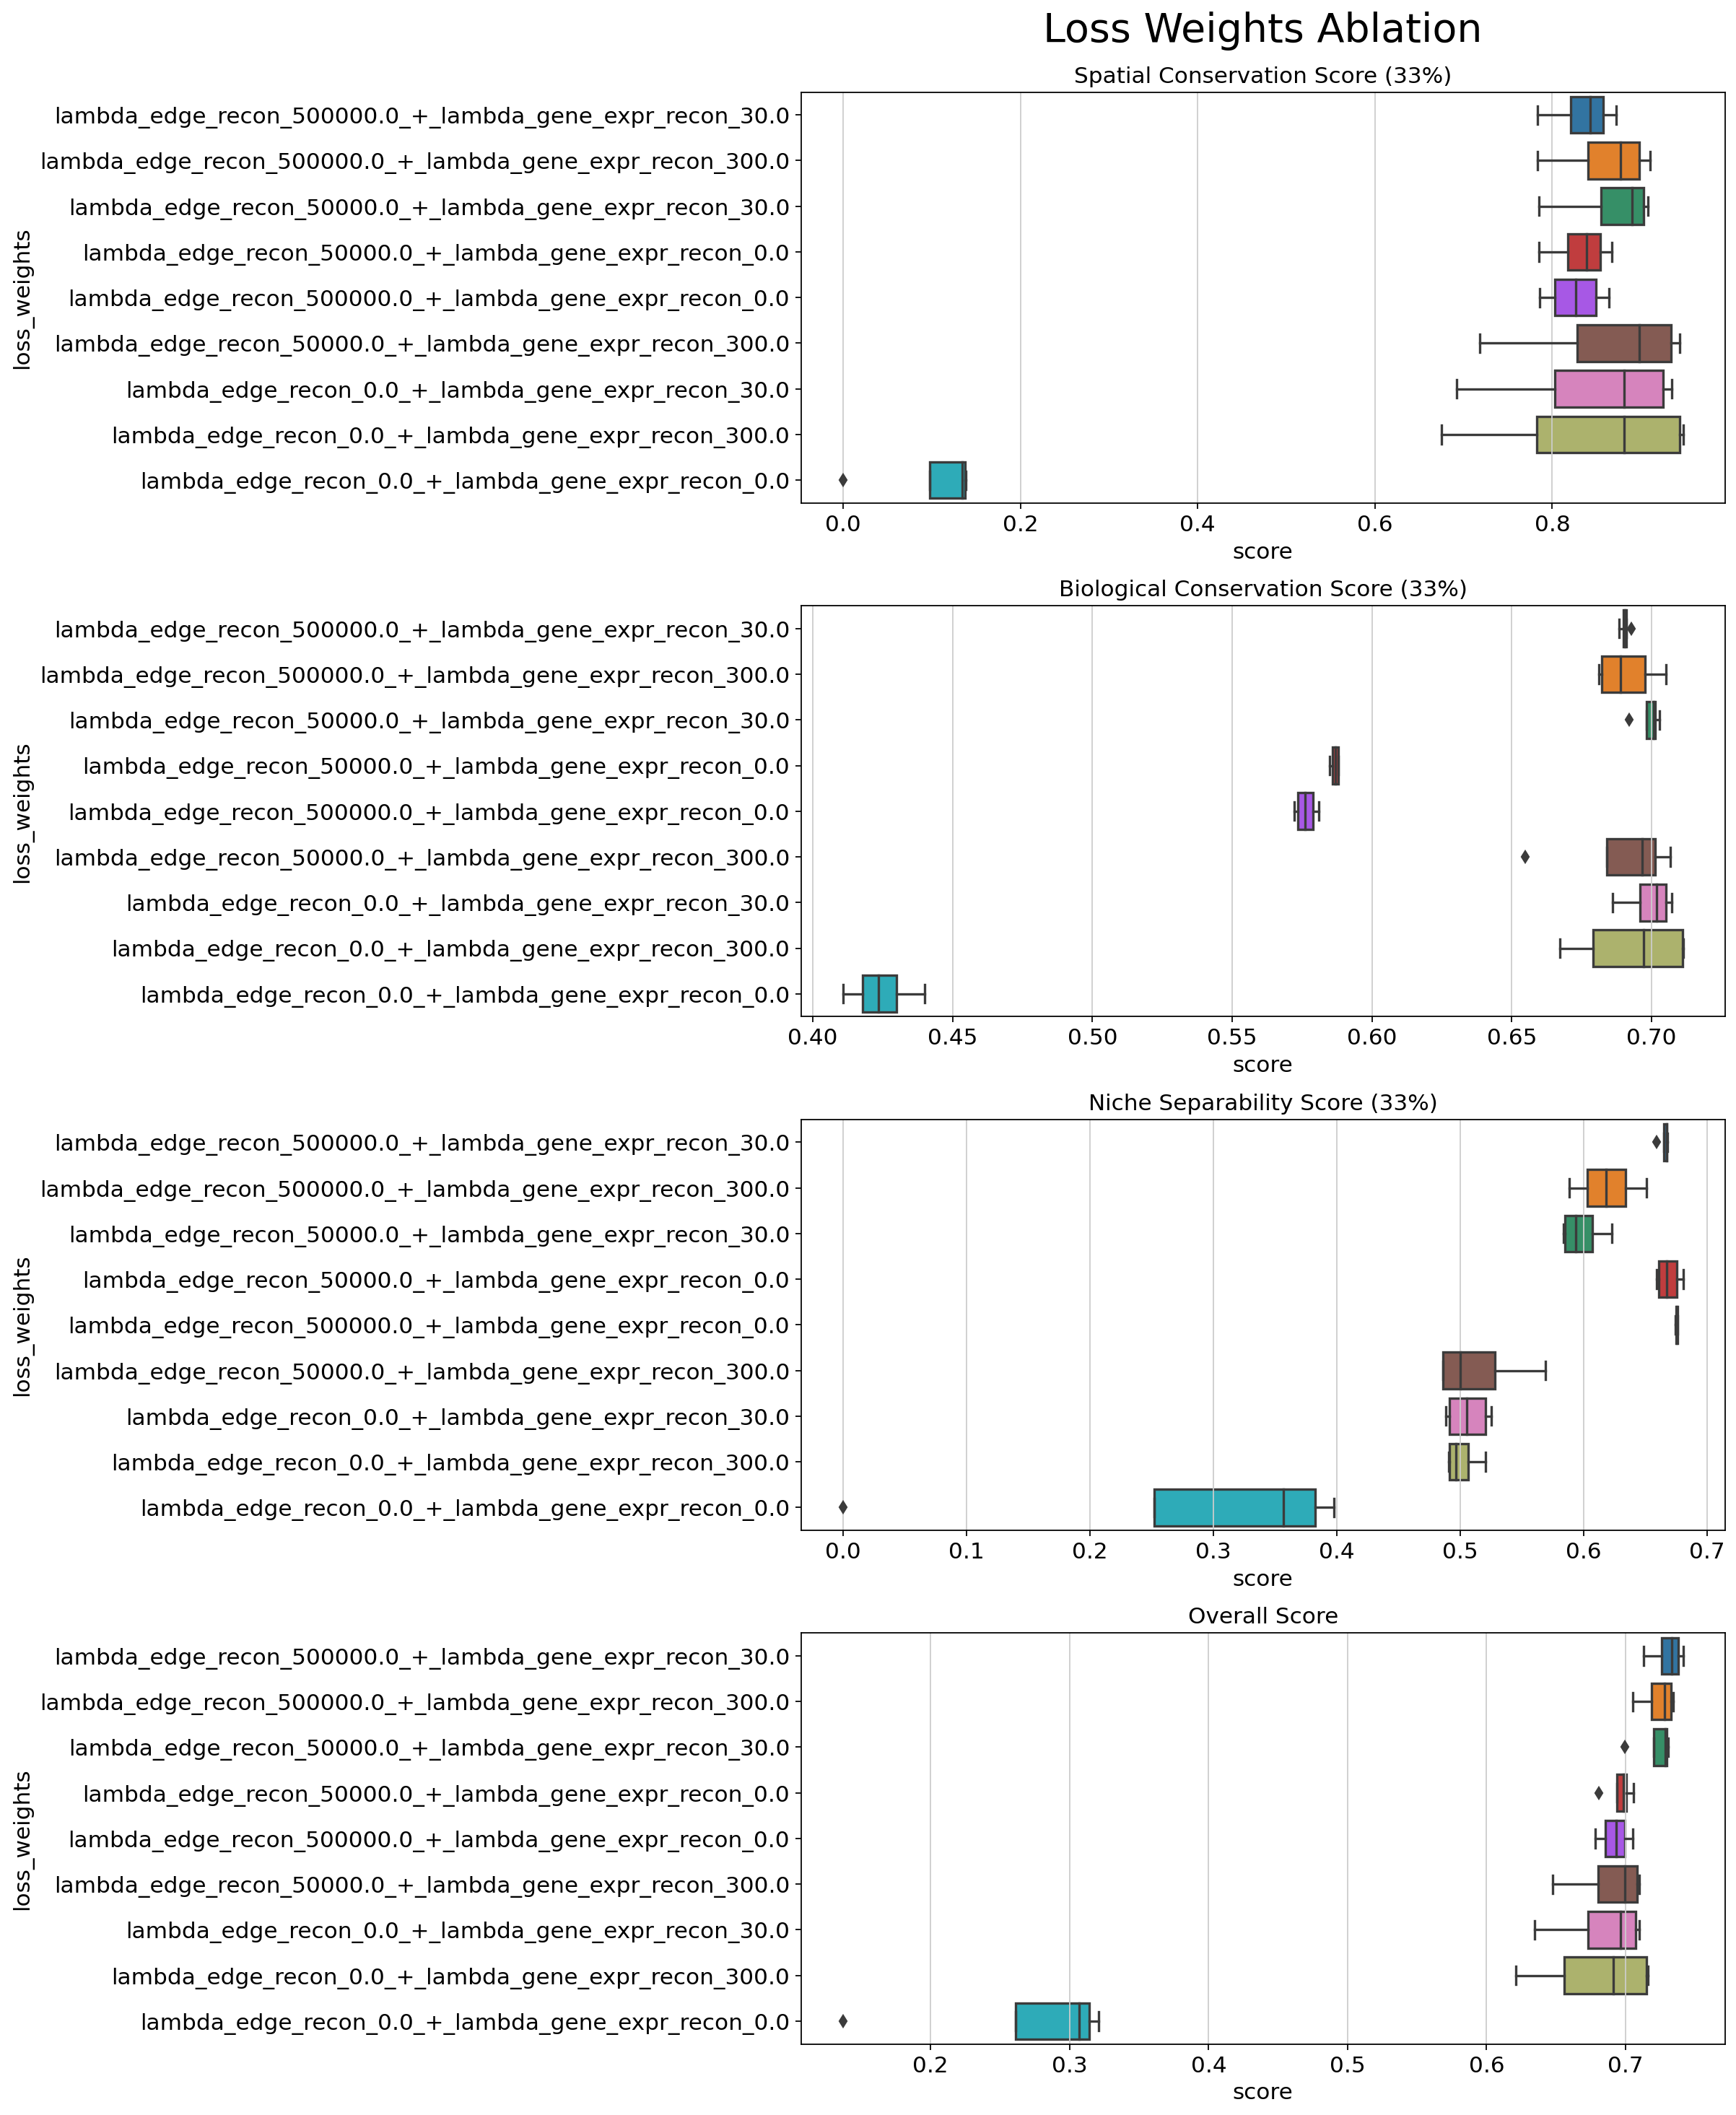

In [35]:
# Plot boxplot with aggregated metrics over all datasets
order = summary_df.groupby(ablation_task).mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"{ablation_task.title().replace('_', ' ')} Ablation",
    df=summary_df,
    group_col=ablation_task,
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_col_titles_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"{ablation_task}_ablation_metrics_boxplot.png")

In [ ]:
# Plot boxplot with all metrics for each dataset individually
for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset]
    order = dataset_df.groupby(ablation_task).mean("Overall Score").sort_values("Overall Score", ascending=False).index
    plot_metrics_boxplot(
        fig_title=f"{ablation_task.title().replace('_', ' ')} Ablation ({dataset})",
        df=dataset_df,
        group_col=ablation_task,
        metric_cols=metric_cols_single_sample + ["Overall Score"], # category_cols_single_sample + ["Overall Score"]
        metric_col_titles=metric_col_titles_single_sample + ["Overall Score"], # category_col_titles_single_sample + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=ablation_folder_path,
        file_name=f"{ablation_task}_ablation_metrics_boxplot_{dataset}.png")

##### 2.1.1.2 GP Mask

In [ ]:
# Plot boxplot with aggregated metrics over all datasets
order = summary_df.groupby("gp_mask").mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"GP Mask Ablation",
    df=summary_df,
    group_col="gp_mask",
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_col_titles_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"gp_mask_ablation_metrics_boxplot.png")

In [ ]:
# Plot boxplot with all metrics for each dataset individually
for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset]
    order = dataset_df.groupby("gp_mask").mean("Overall Score").sort_values("Overall Score", ascending=False).index
    plot_metrics_boxplot(
        fig_title=f"GP Mask Ablation ({dataset})",
        df=dataset_df,
        group_col="gp_mask",
        metric_cols=metric_cols_single_sample + ["Overall Score"], # category_cols_single_sample + ["Overall Score"]
        metric_col_titles=metric_col_titles_single_sample + ["Overall Score"], # category_col_titles_single_sample + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=ablation_folder_path,
        file_name=f"gp_mask_ablation_metrics_boxplot_{dataset}.png")

##### 2.1.1.3 Number of Neighbors

In [ ]:
# Only keep runs with both decoder modules present
filtered_df = summary_df[(summary_df["lambda_edge_recon_"] == 500000.) & (summary_df["lambda_gene_expr_recon_"] == 300.)]

In [ ]:
# Plot boxplot with aggregated metrics over all datasets
order = filtered_df.groupby("n_neighbors").mean("Overall Score").sort_values("Overall Score", ascending=False).index
plot_metrics_boxplot(
    fig_title=f"Number of Neighbors Ablation",
    df=filtered_df,
    group_col="n_neighbors",
    metric_cols=category_cols_single_sample + ["Overall Score"], # metric_cols_single_sample + ["Overall Score"],
    metric_col_titles=category_col_titles_single_sample + ["Overall Score"], # metric_col_titles_single_sample + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=ablation_folder_path,
    file_name=f"n_neighbors_ablation_metrics_boxplot.png")

In [ ]:
# Plot boxplot with all metrics for each dataset individually
for dataset in datasets:
    dataset_df = filtered_df[filtered_df["dataset"] == dataset]
    order = dataset_df.groupby("n_neighbors").mean("Overall Score").sort_values("Overall Score", ascending=False).index
    plot_metrics_boxplot(
        fig_title=f"Number of Neighbors Ablation ({dataset})",
        df=dataset_df,
        group_col="n_neighbors",
        metric_cols=metric_cols_single_sample + ["Overall Score"], # category_cols_single_sample + ["Overall Score"]
        metric_col_titles=metric_col_titles_single_sample + ["Overall Score"], # category_col_titles_single_sample + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=ablation_folder_path,
        file_name=f"n_neighbors_ablation_metrics_boxplot_{dataset}.png")

#### 2.1.2 Plot Metric Tables & Niche Comparison Plots

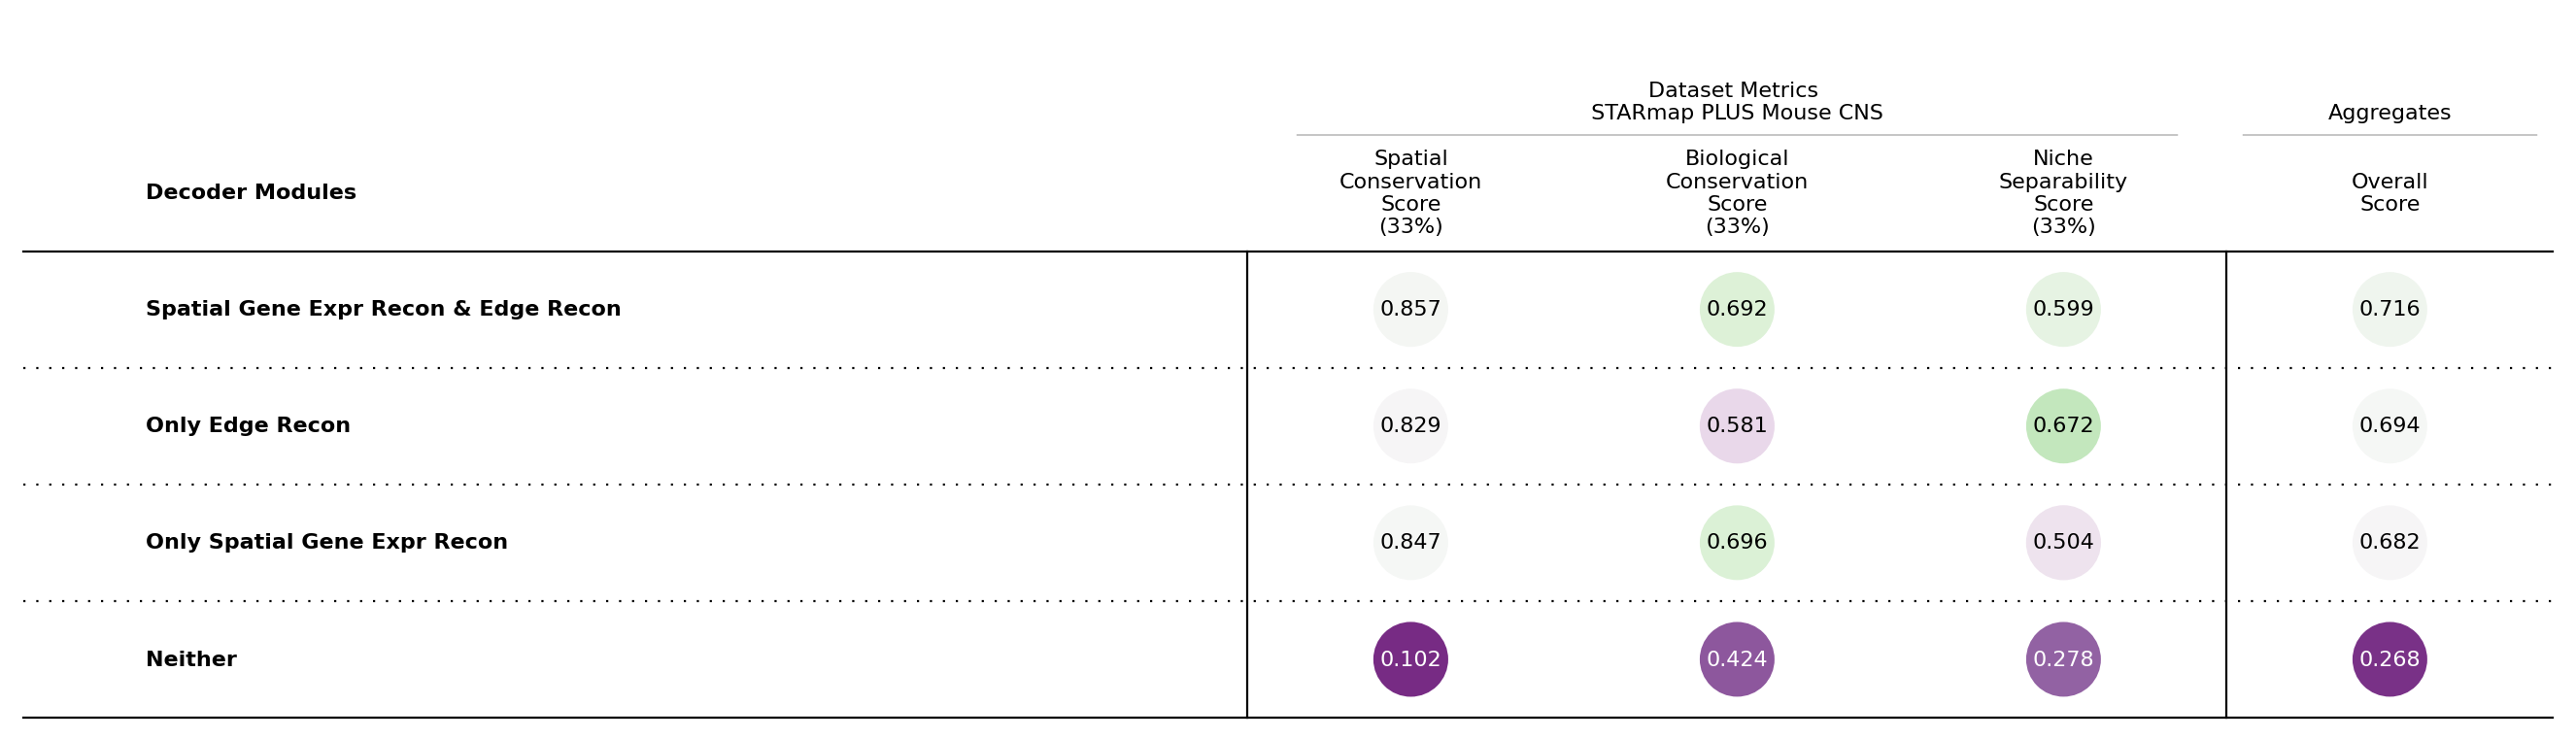

In [36]:
# Plot over aggregated loss weights combinations
summary_df["Decoder Modules"] = summary_df.apply(lambda row: get_loss_weights_combination(row), axis=1)

# Prepare metrics table plot
group_cols = ["dataset", "Decoder Modules"]
aggregate_df = summary_df.groupby(["dataset", "Decoder Modules"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="Decoder Modules",
    ablation_col_width=3.75,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.0, # 0.8,
    plot_width=21, # 32,
    plot_height=6,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"decoder_modules_ablation_aggregated_metrics_table.png")

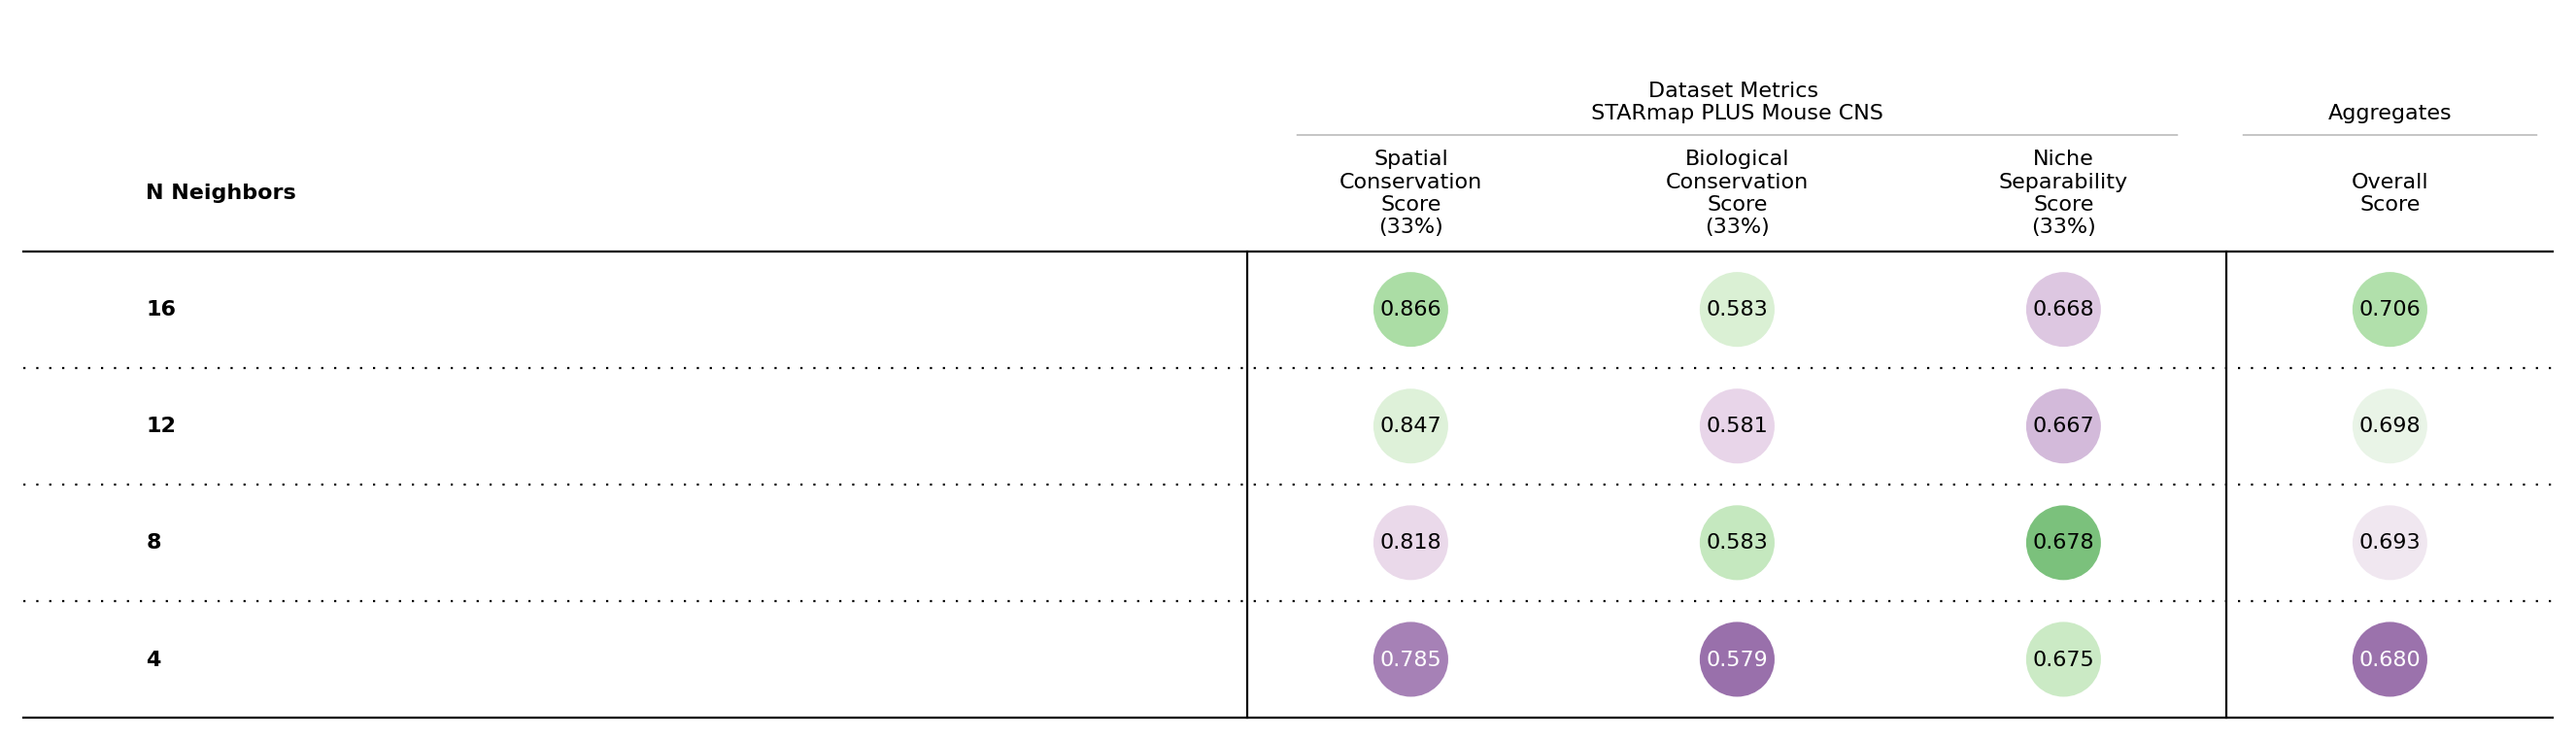

In [42]:
# Plot over number of neighbors (only include both decoder modules present)
#filtered_df = summary_df[(summary_df["lambda_edge_recon_"] != 0.) & (summary_df["lambda_gene_expr_recon_"] != 0.)]
filtered_df = summary_df[(summary_df["Decoder Modules"] == "Only Edge Recon")]

# Prepare metrics table plot
group_cols = ["dataset", "n_neighbors"]
aggregate_df = filtered_df.groupby(["dataset", "n_neighbors"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="n_neighbors",
    ablation_col_width=3.75,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1., # 0.8,
    plot_width=21, # 32,
    plot_height=6,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"n_neighbors_ablation_aggregated_metrics_table.png")

In [ ]:
# 4 neighbors comparison
dataset = "starmap_plus_mouse_cns"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 8 neighbors comparison
dataset = "starmap_plus_mouse_cns"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 12 neighbors comparison
dataset = "starmap_plus_mouse_cns"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 16 neighbors comparison
dataset = "starmap_plus_mouse_cns"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=0.1,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 4 neighbors comparison
dataset = "xenium_human_breast_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 8 neighbors comparison
dataset = "xenium_human_breast_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 12 neighbors comparison
dataset = "xenium_human_breast_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 16 neighbors comparison
dataset = "xenium_human_breast_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "16")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 4 neighbors comparison
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "4")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 8 neighbors comparison
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "8")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# 12 neighbors comparison
dataset = "vizgen_merfish_human_ovarian_cancer"

load_timestamp_gene_expr = summary_df[(summary_df["dataset"] == dataset) &
                                      (summary_df["Decoder Modules"] == "Only Spatial Gene Expr Recon") &
                                      (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_edge_recon = summary_df[(summary_df["dataset"] == dataset) &
                                       (summary_df["Decoder Modules"] == "Only Edge Recon") &
                                       (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]
load_timestamp_both = summary_df[(summary_df["dataset"] == dataset) &
                                 (summary_df["Decoder Modules"] == "Spatial Gene Expr Recon & Edge Recon") &
                                 (summary_df["n_neighbors"] == "12")].sort_values("Overall Score", ascending=False)["timestamp"].values[0]

timestamps = [load_timestamp_gene_expr]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_edge_recon]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

timestamps = [load_timestamp_both]

visualize_niches(artifact_folder_path,
                 dataset,
                 task,
                 timestamps,
                 sample_key,
                 latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30,
                 groups=None,
                 save_fig=True,
                 save_folder_path=ablation_folder_path,
                 file_name=f"loss_weights_ablation_{dataset}_niche_comparison")
gc.collect()

In [ ]:
# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "loss_weights"]
aggregate_df = summary_df.groupby(["dataset", "loss_weights"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col=ablation_task,
    ablation_col_width=9,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5, # 0.8,
    plot_width=25, # 32,
    plot_height=15,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"{ablation_task}_ablation_metrics_table.png")

In [ ]:
# Prepare metrics table plot
group_cols = ["dataset", "gp_mask"]
aggregate_df = summary_df.groupby(["dataset", "gp_mask"]).mean("Overall Score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="gp_mask",
    ablation_col_width=5,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5,
    plot_width=25,
    plot_height=5,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"gp_mask_ablation_metrics_table.png")

In [ ]:
# Prepare metrics table plot
group_cols = ["dataset", "n_neighbors"]
aggregate_df = summary_df.groupby(["dataset", "n_neighbors"]).mean("overall_score").sort_values("Overall Score", ascending=False)[category_cols_single_sample].reset_index() #[metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

# Plot table
plot_metrics_table(
    df=unrolled_df,
    ablation_col="n_neighbors",
    ablation_col_width=9,
    group_col=dataset_col,
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.5, # 0.8,
    plot_width=25, # 32,
    plot_height=15,
    show=True,
    save_dir=ablation_folder_path,
    save_name=f"n_neighbors_ablation_metrics_table.png")

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["01072023_101716_27"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["30062023_143855_10"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

### 2.2 Neighbor Sampling

In [32]:
ablation_task = "neighbor_sampling"
cross_ablation_task = "loss_weights" # for comparison with no neighbor sampling
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type", "cell_type"]
batch_keys = [None, None, None]
experiment_ids = [9, 10, 11]
sample_key = "batch"

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

ablation_col = "neighbor_sampling"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [37]:
# tmp
datasets = ["xenium_human_breast_cancer"]
def scale_metric(metric,
                 reverse=True):
    scaled_metric = math.atan(metric) / (math.pi / 2)
    if reverse:
        scaled_metric = 1 - scaled_metric
    return scaled_metric

import math

In [38]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    
# Define params of interest
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)
summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)
summary_df["geri"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)

In [39]:
# Split into multiple files for each dataset for parallel metrics computation
for dataset in datasets:
    j = 0
    for i in np.arange(0, 22, 2):
        dataset_df = summary_df[summary_df["dataset"] == dataset]
        temp_df = dataset_df[j:i]
        temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
        j = i

In [ ]:
# tmp
datasets = ["starmap_plus_mouse_cns"]

summary_df = pd.read_csv("../../artifacts/neighbor_sampling_ablation/mlflow_summary_neighbor_sampling_ablation_starmap_plus_mouse_cns_10_metrics.csv", index_col=0)
df2 = pd.read_csv("../../artifacts/neighbor_sampling_ablation/mlflow_summary_neighbor_sampling_ablation_starmap_plus_mouse_cns_2_metrics.csv", index_col=0)
df3 = pd.read_csv("../../artifacts/neighbor_sampling_ablation/mlflow_summary_neighbor_sampling_ablation_starmap_plus_mouse_cns_3_metrics.csv", index_col=0)
summary_df = pd.concat([summary_df, df2], ignore_index=True)
summary_df = pd.concat([summary_df, df3], ignore_index=True)

summary2_df = pd.read_csv(f"{ablation_folder_path.replace(ablation_task, cross_ablation_task)}/mlflow_summary_{cross_ablation_task}_ablation_starmap_plus_mouse_cns_metrics_final.csv", index_col=0)

summary2_df = summary2_df[(summary2_df["gp_mask"] == "custom_gp_mask_target_genes_ratio_1.0") &
            ((summary2_df["loss_weights"] == "lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_300.0") | (summary2_df["loss_weights"] == "lambda_edge_recon_50000000.0_+_lambda_gene_expr_recon_30000.0"))]

summary2_df["n_sampled_neighbors"] = -1 

summary_df = pd.concat([summary_df, summary2_df], ignore_index=True)

summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)

In [ ]:
metric_cols

In [ ]:
order

In [ ]:
high_n_neighbors_df

In [ ]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
high_n_neighbors_df = summary_df[summary_df["n_neighbors"].isin([12, 16])]
order = high_n_neighbors_df.groupby("n_sampled_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Neighbor Sampling Ablation",
    df=high_n_neighbors_df,
    group_col="n_sampled_neighbors",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="n_neighbors_ablation_metrics.png")

In [ ]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
middle_neighbors_df = summary_df[summary_df["n_neighbors"].isin([8, 12, 16])]
middle_neighbors_df = middle_neighbors_df[middle_neighbors_df["n_sampled_neighbors"].isin(["2", "4", "-1"])]
order = middle_neighbors_df.groupby("n_sampled_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Neighbor Sampling Ablation",
    df=middle_neighbors_df,
    group_col="n_sampled_neighbors",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=False,
    figure_folder_path=figure_folder_path,
    file_name="loss_weights_ablation_metrics.png")

In [ ]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
low_n_neighbors_df = summary_df[summary_df["n_neighbors"].isin([4, 8, 12, 16])]
low_n_neighbors_df = low_n_neighbors_df[low_n_neighbors_df["n_sampled_neighbors"].isin(["2", "-1"])]
order = low_n_neighbors_df.groupby("n_sampled_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Neighbor Sampling Ablation",
    df=low_n_neighbors_df,
    group_col="n_sampled_neighbors",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=False,
    figure_folder_path=figure_folder_path,
    file_name="loss_weights_ablation_metrics.png")

In [ ]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)

summary2_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path.replace(ablation_task, cross_ablation_task)}/mlflow_summary_{cross_ablation_task}_ablation_{dataset}.csv", index_col=0)
    summary2_df = pd.concat([summary2_df, dataset_df], ignore_index=True)

In [ ]:
# Only keep relevant runs and params from previous ablation
summary2_df = summary2_df[(summary2_df["lambda_edge_recon_"] == 500000.0) &
           (summary2_df["lambda_gene_expr_recon_"] == 300.0) &
           (summary2_df["nichenet_keep_target_genes_ratio"] == 0.01)][
    ["dataset", "timestamp", "val_auroc_score", "val_gene_expr_mse_score", "n_neighbors"]]

summary2_df["n_sampled_neighbors"] = -1 # No neighbor sampling

# tmp
summary_df = summary_df[(summary_df["nichenet_keep_target_genes_ratio"] == 1.0)]

In [ ]:
# tmp
summary_df = pd.read_csv("../../artifacts/neighbor_sampling_ablation/mlflow_summary_neighbor_sampling_ablation_starmap_plus_mouse_cns_1_metrics.csv", index_col=0)
summary_df["lger"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)
summary2_df = pd.read_csv(f"{ablation_folder_path.replace(ablation_task, cross_ablation_task)}/mlflow_summary_{cross_ablation_task}_ablation_{dataset}_metrics_final.csv", index_col=0)

# Only keep relevant runs and params from previous ablation
summary2_df = summary2_df[(summary2_df["lambda_edge_recon_"] == 500000.0) &
           (summary2_df["lambda_gene_expr_recon_"] == 300.0) &
           (summary2_df["nichenet_keep_target_genes_ratio"] == 1.0)][
    ["dataset", "timestamp", "val_auroc_score", "val_gene_expr_mse_score", "n_neighbors", "nichenet_keep_target_genes_ratio"] + metric_cols]

summary2_df["n_sampled_neighbors"] = -1 # No neighbor sampling

summary_df = pd.concat([summary_df, summary2_df], ignore_index=True)
summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)

In [ ]:
summary_df

In [ ]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
order = summary_df.groupby("n_sampled_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Neighbor Sampling Ablation",
    df=summary_df,
    group_col="n_sampled_neighbors",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=False,
    figure_folder_path=figure_folder_path,
    file_name="loss_weights_ablation_metrics.png")

In [ ]:
workspace/projects/nichecompass-reproducibility/artifacts/neighbor_sampling_ablation/mlflow_summary_neighbor_sampling_ablation_starmap_plus_mouse_cns_1_metrics.csv

In [ ]:
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_1.csv", index=False)

In [ ]:
summary_df_filtered = summary_df[(summary_df["n_neighbors"].isin([4, 8, 12, 16])) & (summary_df["n_sampled_neighbors"] == 4)]
summary_df = pd.concat([summary_df_filtered, summary2_df], ignore_index=True)
summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)

In [ ]:
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_processed.csv", index=False)

In [ ]:
summary_df

In [ ]:
# Neighbor sampling comparison vs without plot
plot_metrics(fig_title="Neighbor Sampling Ablation",
             df=summary_df,
             group_col="n_sampled_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="neighbor_sampling_ablation_metrics.png")

### 2.3 Encoder Architecture

In [ ]:
ablation_task = "encoder_architecture"
cross_ablation_task = "loss_weights"
datasets = ["xenium_human_breast_cancer"]
cell_type_keys = ["cell_states"]
batch_keys = [None]
experiment_ids = [7]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_gene_expr_mse_score"] = run.data.metrics.get("val_gene_expr_mse_score", np.nan)
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["n_layers_encoder"] = run.data.params["n_layers_encoder_"]
        run_dict["conv_layer_encoder"] = run.data.params["conv_layer_encoder_"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)

for dataset in datasets:
    summary_df[summary_df["dataset"] == dataset].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")

In [ ]:
summary_df = summary_df[summary_df["n_neighbors"].isin(["4", "8"])]

In [ ]:
# GATv2 vs GCN plot
plot_metrics(fig_title="Encoder Layer Type Ablation",
             df=summary_df,
             group_col="conv_layer_encoder",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="encoder_layer_type_ablation_metrics.png")

#### 2.1.2 Categorical Covariates Contrastive Loss

### 2.5 Spatial Neighborhood Graph

In [ ]:
visualize_niches(artifact_folder_path=artifact_folder_path,
                 dataset=dataset,
                 task=ablation_task + "_ablation",
                 timestamps=timestamps,
                 sample_key="batch",
                 latent_key=latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30.)

### 2.5 Gene Program Mask

In [ ]:
"""
# Log additional mlflow param
run_ids = []
runs_info = mlflow.list_run_infos(3)
for run_info in runs_info:
    run = mlflow.get_run(run_info.run_uuid)
    if "add_fc_gps_instead_of_gp_dict_gps" not in run.data.params:
        run_ids.append(run_info.run_uuid)
        
for run_id in run_ids:
    with mlflow.start_run(run_id=run_id) as run:
        mlflow.log_param("add_fc_gps_instead_of_gp_dict_gps", True)
"""

In [ ]:
# Load data
summary_df = pd.DataFrame()
for dataset in datasets:
    for i in np.arange(20, 240, 20):
        iteration_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv")
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_metrics.csv", index=False)

In [ ]:
result_df[[
        'dataset', 'timestamp', 'loss_weights', 'gp_mask', 'n_neighbors', 'val_auroc_score', 'val_gene_expr_mse_score',
        'lambda_edge_recon_', 'lambda_gene_expr_recon_', 'nichenet_keep_target_genes_ratio', 'add_fc_gps_instead_of_gp_dict_gps',
        'gcs', 'mlami', 'cas', 'clisis', 'geri', 'cari', 'cnmi', 'casw', 'clisi', 'nasw', 'gcs_old', 'mlami_old', 'cas_old']].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics.csv")

In [ ]:
# Unroll points df and compute means over group columns and score type
unrolled_points_df = pd.melt(points_df, 
   id_vars=group_cols,
   value_vars=metric_score_cols,
   var_name="score_type", 
   value_name="score")

# Compute metric means over all runs
mean_points_df = unrolled_points_df.groupby(group_cols + ["score_type"]).mean()
mean_points_df.reset_index(inplace=True)

In [ ]:
mean_points_df

In [ ]:
plot_ablation_points(df=mean_points_df,
                     ablation_col=ablation_col,
                     ablation_col_width=7,
                     group_col=dataset_col,
                     metric_cols=metric_score_cols,
                     show=True,
                     save_dir=None,
                     save_name="ablation_results.svg")

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            task=ablation_task + "_ablation",
                            timestamps=timestamps,
                            dataset="xenium_human_breast_cancer",
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=30.,
                            save_fig=False)

In [ ]:
# tmp
dataset = "starmap_plus_mouse_cns"
dataset_df = summary_df[summary_df["dataset"] == dataset]

column_mapping = {
    'gcs': 'gcs_old',
    'mlami': 'mlami_old',
    'cas': 'cas_old'
}

# Use the rename method with the column_mapping dictionary
dataset_df.rename(columns=column_mapping, inplace=True)

# Split into multiple files for each dataset for parallel metrics computation
j = 200
for i in np.arange(204, 212, 4):
    temp_df = dataset_df[j:i]
    temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
    j = i

In [ ]:
# tmp
datasets = ["vizgen_merfish_human_ovarian_cancer"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 1068, 1072, 1076, 1084, 1064, 1080, 1060, 1004, 1008, 1012, 1044, 1040, 1056, 1020, 1032, 1048, 1036, 1024, 1028, 1052, 2026, 2028, 2006, 2012, 2024, 2010, 2014, 2022, 2020, 2016, 2018, 1016, 2008]:
        iteration_df = pd.read_csv(f"../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_{datasets[0]}_{i}_metrics.csv", index_col=0)
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

summary_df["geri"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)
test_df = summary_df[["dataset", "timestamp"] + metric_cols_single_sample]

df = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_vizgen_merfish_human_ovarian_cancer.csv")

df_combined = df.merge(test_df, on=["dataset", "timestamp"], how="left")
df_combined.drop("Unnamed: 0", axis=1, inplace=True)

# Drop rows with all NaN values
df_filtered = df_combined[df_combined["gcs"].isnull()]

#j = 0
#for i in np.arange(4, 85, 4):
#    temp_df = df_filtered[["dataset", "timestamp", "val_auroc_score", "val_gene_expr_mse_score", "lambda_edge_recon_", "lambda_gene_expr_recon_", "n_neighbors", "nichenet_keep_target_genes_ratio", "add_fc_gps_instead_of_gp_dict_gps"]][j:i]
#    temp_df.to_csv(f"../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_vizgen_merfish_human_ovarian_cancer_{i+1000}.csv")
#    j = i

In [ ]:
adata = sc.read_h5ad("../datasets/srt_data/gold/vizgen_merfish_human_ovarian_cancer_batch2.h5ad")

In [ ]:
df2 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_vizgen_merfish_human_ovarian_cancer_extra10_metrics.csv")
df2["add_fc_gps_instead_of_gp_dict_gps"] = False
df2["loss_weights"] = df2.apply(lambda row: get_loss_weights(row), axis=1)
df2["gp_mask"] = df2.apply(lambda row: get_gp_mask(row), axis=1)
df2["n_neighbors"] = df2["n_neighbors"].astype(str)
df2["geri"] = df2.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)


summary_df = pd.concat([df, df2], ignore_index=True)


summary_df = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics.csv")

summary_df = summary_df[['dataset', 'timestamp', 'loss_weights', 'gp_mask', 'n_neighbors', 'val_auroc_score', 'val_gene_expr_mse_score',
       'lambda_edge_recon_', 'lambda_gene_expr_recon_', 'nichenet_keep_target_genes_ratio', 'add_fc_gps_instead_of_gp_dict_gps',
       'gcs', 'mlami', 'cas', 'clisis', 'geri', 'cari', 'cnmi', 'casw', 'clisi', 'nasw']]


summary_df.to_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics.csv", index=False)

In [ ]:
summary_df[0:3]["timestamp"].tolist()

In [ ]:
summary_df[["dataset", "timestamp", "n_neighbors", "gcs_old", "mlami_old", "cas_old", "clisis", "cari", "cnmi", "casw", "clisi", "nasw"]]

In [ ]:
summary_df["n_neighbors"].astype(int)

In [ ]:
mtc = compute_metrics(artifact_folder_path=artifact_folder_path,
                dataset="starmap_plus_mouse_cns",
                nums_neighbors=summary_df[0:3]["n_neighbors"].astype(int).tolist(),
                task="loss_weights_ablation",
                timestamps=summary_df[0:3]["timestamp"].tolist(),
                cell_type_key="Main_molecular_cell_type",
                batch_key=None,
                spatial_key=spatial_key,
                latent_key=latent_key,
                n_jobs=1,
                metrics=[    "gcs", "mlami", "cas", "clisis", # spatial conservation
    "cari", "cnmi", "casw", "clisi", # biological conservation
    "nasw", # niche identification
                        ],
                file_name="temp.csv")

In [ ]:
summary_df[0:3][["dataset", "n_neighbors", "timestamp", "gcs_old", "mlami_old", "cas_old"]]

In [ ]:
summary_df.rename({"gcs": "gcs_old"}, axis=1, inplace=True)

In [ ]:
summary_df

In [ ]:
summary_df.rename({"mlami": "mlami_old"}, axis=1, inplace=True)

In [ ]:
summary_df.rename({"cas": "cas_old"}, axis=1, inplace=True)

In [ ]:
summary_df = summary_df[summary_df["dataset"] == "starmap_plus_mouse_cns"]

In [ ]:
2+3

In [ ]:
summary_df.set_index(['dataset', 'timestamp'], inplace=True)
mtc.set_index(['dataset', 'timestamp'], inplace=True)

# Fill NaN values in df1 with non-NaN values from df2
result_df = summary_df.combine_first(mtc)

# Reset the index to bring 'key1' and 'key2' columns back as regular columns
result_df.reset_index(inplace=True)

In [ ]:
df = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_4.csv", index_col=0)
df2 = pd.read_csv("../../artifacts/loss_weights_ablation/temp_metrics_temp11.csv", index_col=0)
df3 = pd.read_csv("../../artifacts/loss_weights_ablation/temp_metrics_temp12.csv", index_col=0)
df4 = pd.read_csv("../../artifacts/loss_weights_ablation/temp_metrics_temp13.csv", index_col=0)
df_extra = pd.concat([df2, df3, df4], axis=0)
df = df.merge(df_extra, on=["dataset", "timestamp"])
df.to_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_4_metrics.csv")